# Is there a relationship between times of recession and other key indicators?

May 2016

Written by Zijie (Jason) Ou at NYU Stern, with a lot of help from google.

Contact: jason.ou@nyu.edu

Are past periods of economic downturn associated with other factors such as the national rate of unemployment, the fed funds rate, money supply, among  other factors? I decided to take a closer look, and ultimately build a rough prediction model to determine (very roughly) when the next recession may be.

## Packages Imported

Pandas, numpy, and matplotlib imported to handle basic dataframe/graphical analysis. I access FRED data through pandas.io.web.

I later use **scipy** to do some statistical tests, and multiple packages from **sklearn** to create a rough Logistic Regression model.

In [292]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas.io.data as web
import datetime
import numpy as np
from scipy import stats
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

#start, end times used as parameters when pulling data from FRED.
start = datetime.datetime(1960, 1,1)
end= datetime.datetime(2016,5,11)


## Importing the Data

An individual pandas dataframe is created for each imported data set.

In [293]:
gdp=web.DataReader("GDPC1",'fred',start,end)
#real GDP quarterly

gdpchange=web.DataReader("A191RL1Q225SBEA",'fred',start,end)
#real GDP change from preceding period quarterly

CPIurban=web.DataReader("CPIAUCSL",'fred',start,end)
#CPI quarterly, monthly, urban consumers

fedfunds=web.DataReader("FEDFUNDS",'fred',start,end)
#monthly fed funds rate

unemployment=web.DataReader("UNRATE",'fred',start,end)
#monthly unemployment rate

civpart=web.DataReader("CIVPART",'fred',start,end)
#monthly laborforce participation

tenyear=web.DataReader("GS10",'fred',start,end)
#monthly fed funds rate

m2v=web.DataReader("M2V",'fred',start,end)
#monthly m2 velocity

industrial=m2v=web.DataReader("INDPRO",'fred',start,end)
#monthly industrial production index


## Fixing Datasets

The initial problem I encountered was that many of the datasets I collected from FRED did not share the same timescale, preventing any analysis. To fix this, I resampled each dataset to fall in line with the quarterly GDP reporting time scale, and truncated as necessary so all the dates matched.

In addition, for each dataset, I figured it would also be useful to add a new rate of change column for each dataset.

In [294]:
#Quarterly TimeGrouper
g=pd.TimeGrouper(freq='Q')

#Resampling monthly data into quarterly using the TimeGrouper
gdp3m=gdp.resample('Q',how='mean')

gdpchange3m=gdpchange.resample('Q',how='mean')
gdpchange3m=gdpchange3m[1:]
gdpchange3m.columns=['GDP_growth']

#For many of the datasets, including CPI, I created a new rate of change column.
CPIurban3m = CPIurban.groupby(g).mean()
CPIurban3m.columns=['CPI']
CPIurban3m['rate']=CPIurban3m['CPI'].pct_change()
CPIurban3m=CPIurban3m[1:]

unemployment3m=unemployment.groupby(g).mean()
unemployment3m.columns=['Unemployment Rate']
unemployment3m['Percent Change']=unemployment3m['Unemployment Rate'].pct_change()
unemployment3m=unemployment3m[1:]

fedfunds3m=fedfunds.groupby(g).mean()
fedfunds3m.columns=['FedFundsRate']
fedfunds3m['Percent Change']=fedfunds3m['FedFundsRate'].pct_change()
fedfunds3m=fedfunds3m[1:]

civpart3m=civpart.groupby(g).mean()
civpart3m.columns=['CivLabourPart']
civpart3m['Percent Change']=civpart3m['CivLabourPart'].pct_change()
civpart3m=civpart3m[1:]

tenyear3m=tenyear.groupby(g).mean()
tenyear3m.columns=['10YearBond']
tenyear3m['Percent Change']=tenyear3m['10YearBond'].pct_change()
tenyear3m=tenyear3m[1:]

m2v3m=m2v.groupby(g).mean()
m2v3m.columns=['M2Velocity']
m2v3m['Percent Change']=m2v3m['M2Velocity'].pct_change()
m2v3m=m2v3m[1:]

industrial3m=industrial.groupby(g).mean()
industrial3m.columns=['Production Index']
industrial3m['Percent Change']=industrial3m['Production Index'].pct_change()
industrial3m=industrial3m[1:]


## Combining the Data Into a Single Dataset

Now that I cleaned up all of my datasets, they're ready to be combined.

In [295]:
final=gdpchange3m
final['CPI_growth']=CPIurban3m['rate']
final['Unemployment_Rate']=unemployment3m['Unemployment Rate']
final['Unemployment_Rate_growth']=unemployment3m['Percent Change']
final['Fed_Funds_Rate']=fedfunds3m['FedFundsRate']
final['Fed_Funds_Rate_growth']=fedfunds3m['Percent Change']
final['Civ_Labour_Part']=civpart3m['CivLabourPart']
final['Civ_Labour_Part_growth']=civpart3m['Percent Change']
final['Ten_Year_Bond']=tenyear3m['10YearBond']
final['Ten_Year_Bond_growth']=tenyear3m['Percent Change']
final['M2_Velocity']=m2v3m['M2Velocity']
final['M2_Velocity_growth']=m2v3m['Percent Change']
final['Production_Index_growth'] = industrial3m['Percent Change']

rowCount=len(final.index)



Final dataset looks good. No alignment issues here.

In [296]:
final

,GDP_growth,CPI_growth,Unemployment_Rate,Unemployment_Rate_growth,Fed_Funds_Rate,Fed_Funds_Rate_growth,Civ_Labour_Part,Civ_Labour_Part_growth,Ten_Year_Bond,Ten_Year_Bond_growth,M2_Velocity,M2_Velocity_growth,Production_Index_growth
DATE,,,,,,,,,,,,,
1960-06-30,-1.5,0.006010,5.233333,0.019481,3.696667,-0.060169,59.566667,1.131862e-02,4.260000,-0.050520,24.360867,-0.021699,-0.021699
1960-09-30,1.0,0.000564,5.533333,0.057325,2.936667,-0.205591,59.566667,0.000000e+00,3.833333,-0.100156,23.960300,-0.016443,-0.016443
1960-12-31,-4.8,0.006421,6.266667,0.132530,2.296667,-0.217934,59.633333,1.119194e-03,3.886667,0.013913,23.382733,-0.024105,-0.024105
1961-03-31,2.7,0.002015,6.800000,0.085106,2.003333,-0.127721,59.633333,2.220446e-16,3.786667,-0.025729,23.028733,-0.015139,-0.015139
1961-06-30,7.6,-0.000335,7.000000,0.029412,1.733333,-0.134775,59.466667,-2.794857e-03,3.790000,0.000880,23.941700,0.039645,0.039645
1961-09-30,6.8,0.003911,6.766667,-0.033333,1.683333,-0.028846,59.200000,-4.484305e-03,3.980000,0.050132,24.705567,0.031905,0.031905
1961-12-31,8.3,0.001447,6.200000,-0.083744,2.400000,0.425743,59.000000,-3.378378e-03,3.973333,-0.001675,25.571933,0.035068,0.035068
1962-03-31,7.4,0.003890,5.633333,-0.091398,2.456667,0.023611,58.900000,-1.694915e-03,4.016667,0.010906,25.953867,0.014936,0.014936
1962-06-30,4.4,0.003764,5.533333,-0.017751,2.606667,0.061058,58.800000,-1.697793e-03,3.873333,-0.035685,26.205400,0.009692,0.009692


For the sake of analysis, I realized I would also need to create a similar dataset where each row corresponds to a recession year. This way, I could compare each indicator's performance across all years with performance only in recession years.

In [297]:
finalOnlyNegatives = pd.DataFrame(np.nan, index=[0], columns=final.columns)
for index, row in final.iterrows():
    if(row['GDP_growth'] < 0):
        finalOnlyNegatives.loc[finalOnlyNegatives.index.max()+1]=row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],row[12]
finalOnlyNegatives=finalOnlyNegatives[1:]

finalRowCount=len(finalOnlyNegatives.index)

finalOnlyNegatives

,GDP_growth,CPI_growth,Unemployment_Rate,Unemployment_Rate_growth,Fed_Funds_Rate,Fed_Funds_Rate_growth,Civ_Labour_Part,Civ_Labour_Part_growth,Ten_Year_Bond,Ten_Year_Bond_growth,M2_Velocity,M2_Velocity_growth,Production_Index_growth
1,-1.5,0.006010,5.233333,0.019481,3.696667,-0.060169,59.566667,1.131862e-02,4.260000,-0.050520,24.360867,-0.021699,-0.021699
2,-4.8,0.006421,6.266667,0.132530,2.296667,-0.217934,59.633333,1.119194e-03,3.886667,0.013913,23.382733,-0.024105,-0.024105
3,-1.7,0.015343,3.566667,0.000000,8.940000,-0.004824,60.266667,5.534034e-04,7.296667,0.064171,40.377767,-0.006269,-0.006269
4,-0.7,0.016000,4.166667,0.168224,8.573333,-0.041014,60.466667,3.318584e-03,7.366667,0.009593,39.399533,-0.024227,-0.024227
5,-4.0,0.014518,5.833333,0.129032,5.566667,-0.169567,60.400000,1.658375e-03,6.853333,-0.081323,38.198500,-0.021618,-0.021618
6,-2.2,0.019727,4.800000,-0.027027,10.560000,0.350959,60.800000,5.485464e-04,7.206667,0.058766,46.958500,0.008727,0.008727
7,-3.3,0.029753,5.133333,0.076923,9.323333,-0.067356,61.333333,3.818876e-03,7.053333,0.044423,47.236600,-0.008785,-0.008785
8,-3.8,0.028140,5.633333,0.083333,12.090000,0.074667,61.333333,2.724796e-03,7.963333,0.055678,47.076800,-0.004123,-0.004123
9,-1.6,0.030708,6.600000,0.171598,9.346667,-0.226909,61.266667,-1.086957e-03,7.670000,-0.036835,45.201900,-0.039826,-0.039826
10,-4.7,0.021373,8.266667,0.252525,6.303333,-0.325606,61.200000,-1.088139e-03,7.540000,-0.016949,42.208733,-0.066218,-0.066218


## Analysis

Look good. Out of 224 recorded quarters, there are only 27 quarters of negative GDP growth. 

Now lets dive deeper and see how the indicators differ in times of recession and across all quarters. The methodology is as follows:

For each indicator, determine the % of the time where growth is positive from the initial dataframe containing all records. This is where the rate of change column I created for each indicator comes in handy. 

I can then compare this percentage with the percentage of the time where the indicator's growth is positive from the negative-GDP-growth-only data frame. 

For the sake of statistical soundness, I also perform a 2-tailed Proportion p-test to determine which differences are statistically significant. 

In [298]:
#cpi % positive growth across all quarters, compared with 
CPIcount=0
for index, row in final.iterrows():
    if(row['CPI_growth'] > 0):
        CPIcount=CPIcount+1
CPIpercent = (CPIcount/rowCount)

#CPI % positive growth across negative GDP growth quarters.
newCPICount = 0
for index, row in finalOnlyNegatives.iterrows():
    if(row['CPI_growth'] > 0):
        newCPICount=newCPICount+1
newCPIpercent = (newCPICount/finalRowCount)

#CPI 2-tailed Proportion p-test of significance
CPIz=np.array([[rowCount,CPIcount],[finalRowCount,newCPICount]])
CPIp=(stats.chi2_contingency(CPIz)[1])

#The same is done for each of the indicators

#unemployment rate growth average and negative-only 
unemploymentCount=0
for index, row in final.iterrows():
    if(row['Unemployment_Rate_growth'] > 0):
        unemploymentCount=unemploymentCount+1
unemploymentPercent = (unemploymentCount/rowCount)

newUnemploymentCount = 0
for index, row in finalOnlyNegatives.iterrows():
    if(row['Unemployment_Rate_growth'] > 0):
        newUnemploymentCount=newUnemploymentCount+1
newUnemploymentPercent = (newUnemploymentCount/finalRowCount)
    
unemploymentz=np.array([[rowCount,unemploymentCount],[finalRowCount,newUnemploymentCount]])
unemploymentp=(stats.chi2_contingency(unemploymentz)[1])

#fed funds rate average and negative-only 
fedfundscount=0
for index, row in final.iterrows():
    if(row['Fed_Funds_Rate_growth'] > 0):
        fedfundscount=fedfundscount+1
fedfundspercent = (fedfundscount/rowCount)

newfedfundscount = 0
for index, row in finalOnlyNegatives.iterrows():
    if(row['Fed_Funds_Rate_growth'] > 0):
        newfedfundscount=newfedfundscount+1
newFedFundsPercent = (newfedfundscount/finalRowCount)
    
fedfundsz=np.array([[rowCount,fedfundscount],[finalRowCount,newfedfundscount]])
fedfundsp=(stats.chi2_contingency(fedfundsz)[1])

#civ labour participation rate average and negative-only 
civlaborcount=0
for index, row in final.iterrows():
    if(row['Civ_Labour_Part_growth'] > 0):
        civlaborcount=civlaborcount+1
civlabourpercent = (civlaborcount/rowCount)

newcivlaborcount = 0
for index, row in finalOnlyNegatives.iterrows():
    if(row['Civ_Labour_Part_growth'] > 0):
        newcivlaborcount=newcivlaborcount+1
newcivlaborpercent = (newcivlaborcount/finalRowCount)
    
civlabourz=np.array([[rowCount,civlaborcount],[finalRowCount,newcivlaborcount]])
civlabourp=(stats.chi2_contingency(civlabourz)[1])

#ten year bond rate average and negative-only 
tenyearcount=0
for index, row in final.iterrows():
    if(row['Ten_Year_Bond_growth'] > 0):
        tenyearcount=tenyearcount+1
tenyearpercent = (tenyearcount/rowCount)

newtenyearcount = 0
for index, row in finalOnlyNegatives.iterrows():
    if(row['Ten_Year_Bond_growth'] > 0):
        newtenyearcount=newtenyearcount+1
newtenyearpercent = (newtenyearcount/finalRowCount)
    
tenyearz=np.array([[rowCount,tenyearcount],[finalRowCount,newtenyearcount]])
tenyearp=(stats.chi2_contingency(tenyearz)[1])

#M2 velocity average and negative-only 
m2count=0
for index, row in final.iterrows():
    if(row['M2_Velocity_growth'] > 0):
        m2count=m2count+1
m2percent = (m2count/rowCount)

newm2count = 0
for index, row in finalOnlyNegatives.iterrows():
    if(row['M2_Velocity_growth'] > 0):
        newm2count=newm2count+1
newm2percent = (newm2count/finalRowCount)
    
m2z=np.array([[rowCount,m2count],[finalRowCount,newm2count]])
m2p=(stats.chi2_contingency(m2z)[1])

#Production Index Growth average and negative-only 
productioncount=0
for index, row in final.iterrows():
    if(row['Production_Index_growth'] > 0):
        productioncount=productioncount+1
productionpercent = (productioncount/rowCount)

newproductioncount = 0
for index, row in finalOnlyNegatives.iterrows():
    if(row['Production_Index_growth'] > 0):
        newproductioncount=newproductioncount+1
newproductionpercent = (newproductioncount/finalRowCount)
    
productionz=np.array([[rowCount,productioncount],[finalRowCount,newproductioncount]])
productionp=(stats.chi2_contingency(productionz)[1])


Now let's create a new dataframe to store the results.

In [299]:
beforeAfterCompare = pd.DataFrame(np.nan, index=[0], columns=final.columns)
beforeAfterCompare=beforeAfterCompare.drop('GDP_growth',axis=1)
beforeAfterCompare=beforeAfterCompare.drop('Fed_Funds_Rate',axis=1)
beforeAfterCompare=beforeAfterCompare.drop('Unemployment_Rate',axis=1)
beforeAfterCompare=beforeAfterCompare.drop('Civ_Labour_Part',axis=1)
beforeAfterCompare=beforeAfterCompare.drop('Ten_Year_Bond',axis=1)
beforeAfterCompare=beforeAfterCompare.drop('M2_Velocity',axis=1)
beforeAfterCompare['Type']=""

beforeAfterCompare.loc[0]=CPIpercent,unemploymentPercent,fedfundspercent,civlabourpercent,tenyearpercent,m2percent,productionpercent,'All Quarters'
beforeAfterCompare.loc[1]=newCPIpercent,newUnemploymentPercent,newFedFundsPercent,newcivlaborpercent,newtenyearpercent,newm2percent,newproductionpercent,'Recession Quarters'

beforeAfterCompare=beforeAfterCompare.set_index('Type')
beforeAfterCompare



,CPI_growth,Unemployment_Rate_growth,Fed_Funds_Rate_growth,Civ_Labour_Part_growth,Ten_Year_Bond_growth,M2_Velocity_growth,Production_Index_growth
Type,,,,,,,
All Quarters,0.946429,0.348214,0.508929,0.508929,0.526786,0.767857,0.767857
Recession Quarters,0.925926,0.814815,0.148148,0.592593,0.444444,0.148148,0.148148


Looks good! With this dataframe we can clearly identify some indicators whose positive growth rates differs significantly when GDP growth is negative and across all quarters.

Namely, the **unemployment rate** increases only 34% of the time across all periods, but increases 81% of the time in times of recession. Other factors, such as the **fed funds rate** and the **M2 Velocity** also differ substantially.

Other factors differ moderately, or barely at all such as with **CPI growth**.

Just to confirm that these changes are significant, lets see what the p-values are. 



In [300]:

significance = pd.DataFrame(np.nan, index=[0], columns=beforeAfterCompare.columns)

significance.loc[0]=CPIp,unemploymentp,fedfundsp,civlabourp,tenyearp,m2p,productionp,
significance


,CPI_growth,Unemployment_Rate_growth,Fed_Funds_Rate_growth,Civ_Labour_Part_growth,Ten_Year_Bond_growth,M2_Velocity_growth,Production_Index_growth
0,0.942456,0.010091,0.029397,0.777339,0.773569,0.001711,0.001711


Looks good. This confirms that those factors that differ substantially have low p-values, which signifies statistical significance. (Under .05 is a good cut off here.)

## Visualization

Lets visualize this analysis.

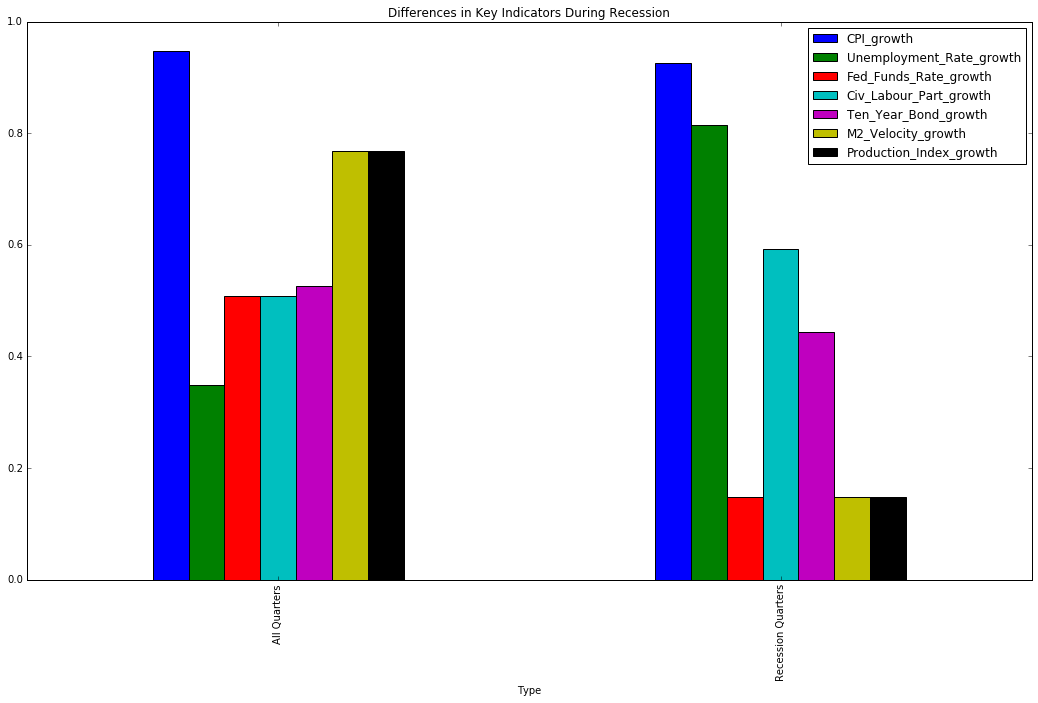

In [301]:


fig, ax = plt.subplots(figsize=(18,10))

beforeAfterCompare.plot(ax=ax,kind='bar',title='Differences in Key Indicators During Recession')

In addition to comparing the percentage of the time where the indicator experiences positive growth, we can also compare the average value of the indicator across all time periods vs periods of negative GDP growth. 

This analysis is split into two graphs in order to better see the differences.

In [302]:
final=final.reset_index()

final['Recession']=(final.GDP_growth < 0).astype(float)
finalvalues=final.groupby('Recession').mean()

finalvalues=finalvalues.drop("GDP_growth",axis=1)
finalvalues=finalvalues.drop("CPI_growth",axis=1)
finalvalues=finalvalues.drop("Unemployment_Rate_growth",axis=1)
finalvalues=finalvalues.drop("Fed_Funds_Rate_growth",axis=1)
finalvalues=finalvalues.drop("Civ_Labour_Part_growth",axis=1)
finalvalues=finalvalues.drop("Ten_Year_Bond_growth",axis=1)
finalvalues=finalvalues.drop("M2_Velocity_growth",axis=1)
finalvalues=finalvalues.drop("Production_Index_growth",axis=1)
finalvalues2=finalvalues
finalvalues=finalvalues.drop("Civ_Labour_Part",axis=1)
finalvalues=finalvalues.drop("M2_Velocity",axis=1)

finalvalues

,Unemployment_Rate,Fed_Funds_Rate,Ten_Year_Bond
Recession,,,
0,6.023858,5.015939,6.188088
1,6.585185,6.862840,7.158148


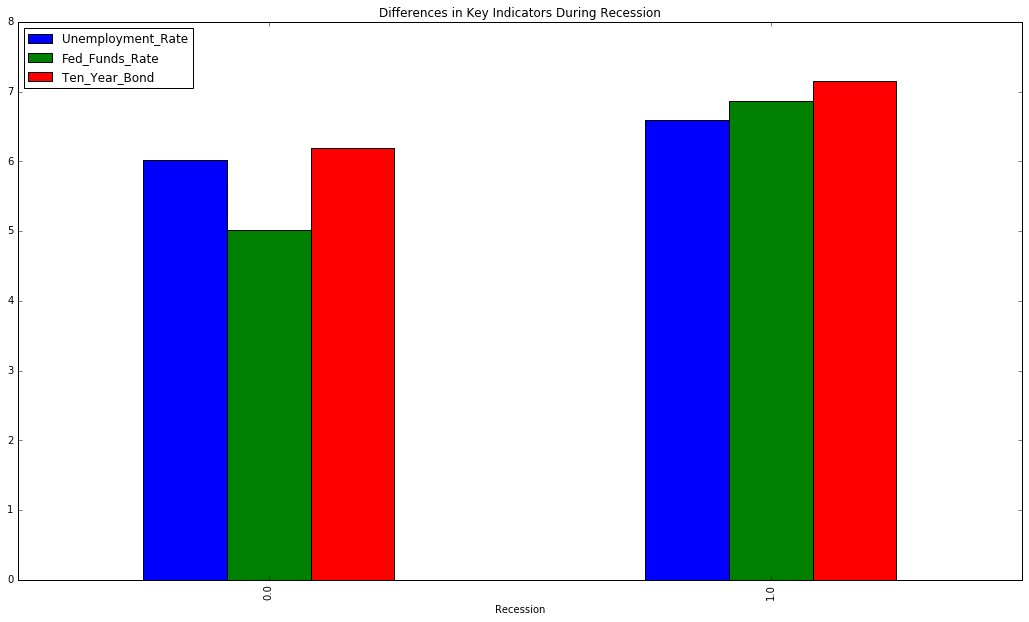

In [303]:


fig, ax = plt.subplots(figsize=(18,10))

finalvalues.plot(ax=ax,kind='bar',title='Differences in Key Indicators During Recession')

In [304]:
finalvalues2=finalvalues2.drop("Unemployment_Rate",axis=1)
finalvalues2=finalvalues2.drop("Fed_Funds_Rate",axis=1)
finalvalues2=finalvalues2.drop("Ten_Year_Bond",axis=1)
finalvalues2

,Civ_Labour_Part,M2_Velocity
Recession,,
0,63.718613,66.263488
1,63.429630,62.881799


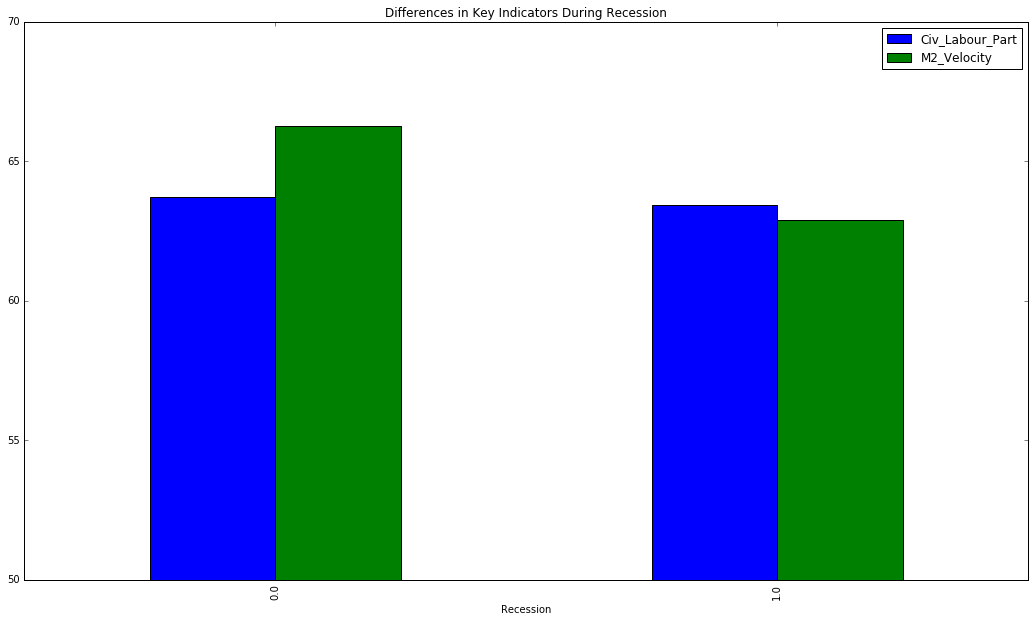

In [305]:


fig, ax = plt.subplots(figsize=(18,10))

finalvalues2.plot(ax=ax,kind='bar',title='Differences in Key Indicators During Recession',ylim=(50,70))

## Finally, a Prediction Model

I created a train/test logistic regression model using SKlearn, which ultimately resulted in a moderately successful model. Since negative gdp growth occured in only 12% of periods, the null success rate here is 88%. If one guessed that every period would have no recession, they would be right 88% of the time.

This model is 92.6% accurate, which is little more than a third better than just guessing. This goes to show that it is difficult to create a prediction model for recessions from these indicators alone. Still, its better than nothing.

In [306]:
y, X = dmatrices('Recession ~ CPI_growth + Unemployment_Rate + Unemployment_Rate_growth + Fed_Funds_Rate + Civ_Labour_Part + Ten_Year_Bond+ M2_Velocity', final,return_type="dataframe")

In [307]:
y = np.ravel(y)

In [308]:
#this is the % of the time negative gdp growth occured.
y.mean()

0.12053571428571429

In [309]:
#creating test, train data sets, with test size of 30%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2)
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [310]:
# predict class labels for the test set
predicted = model.predict(X_test)
print (predicted)
#making sure there is an occurance of negative GDP growth in the test set.

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [315]:
# This is the accuracy, 92.6%
print (metrics.accuracy_score(y_test, predicted))

0.926470588235


## Conclusion

Predicting GDP decline is hard stuff! Its obvious that there is a correlation with certain indicators, such as unemployment, the fed funds rate, and M2 velocity, but this is still just correlation. 

Still, combining the moderately successful model with an awareness of the current status of these indicators would be a pretty good bet. If the model is predicting a period of negative GDP growth, and the correlated indicators are also in line with recession values, its likely a recession is right around the corner.

## Data Sources

FRED